## RNN으로 주식 데이터 예측

In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')


In [93]:
# 삼성전자 주식 데이터
df = pd.read_csv('../data/005930.KS.csv', parse_dates=['Date'])
df.set_index('Date', inplace=True)
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-04,6000.0,6110.0,5660.0,6110.0,4514.581543,74195000
2000-01-05,5800.0,6060.0,5520.0,5580.0,4122.972656,74680000
2000-01-06,5750.0,5780.0,5580.0,5620.0,4152.526855,54390000
2000-01-07,5560.0,5670.0,5360.0,5540.0,4093.417969,40305000
2000-01-10,5600.0,5770.0,5580.0,5770.0,4263.360352,46880000
...,...,...,...,...,...,...
2023-12-26,76100.0,76700.0,75700.0,76600.0,76600.000000,13164909
2023-12-27,76700.0,78000.0,76500.0,78000.0,78000.000000,20651042
2023-12-28,77700.0,78500.0,77500.0,78500.0,78500.000000,17797536


In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6019 entries, 2000-01-04 to 2024-01-03
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       6019 non-null   float64
 1   High       6019 non-null   float64
 2   Low        6019 non-null   float64
 3   Close      6019 non-null   float64
 4   Adj Close  6019 non-null   float64
 5   Volume     6019 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 329.2 KB


In [95]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,6019.000000,6019.000000,6019.000000,6019.000000,6019.000000,6.019000e+03
mean,27504.161821,27771.732846,27228.245556,27497.268649,23914.809723,2.119537e+07
std,21833.094150,22003.097918,21650.590156,21817.013165,21402.014837,1.515231e+07
min,2540.000000,2760.000000,2420.000000,2730.000000,2017.153564,0.000000e+00
25%,10560.000000,10730.000000,10420.000000,10560.000000,7940.695801,1.164138e+07
50%,19100.000000,19320.000000,18860.000000,19160.000000,14986.499023,1.710540e+07
75%,44300.000000,44825.000000,43800.000000,44325.000000,38643.414062,2.631302e+07
max,90300.000000,96800.000000,89500.000000,91000.000000,86286.703125,1.642150e+08


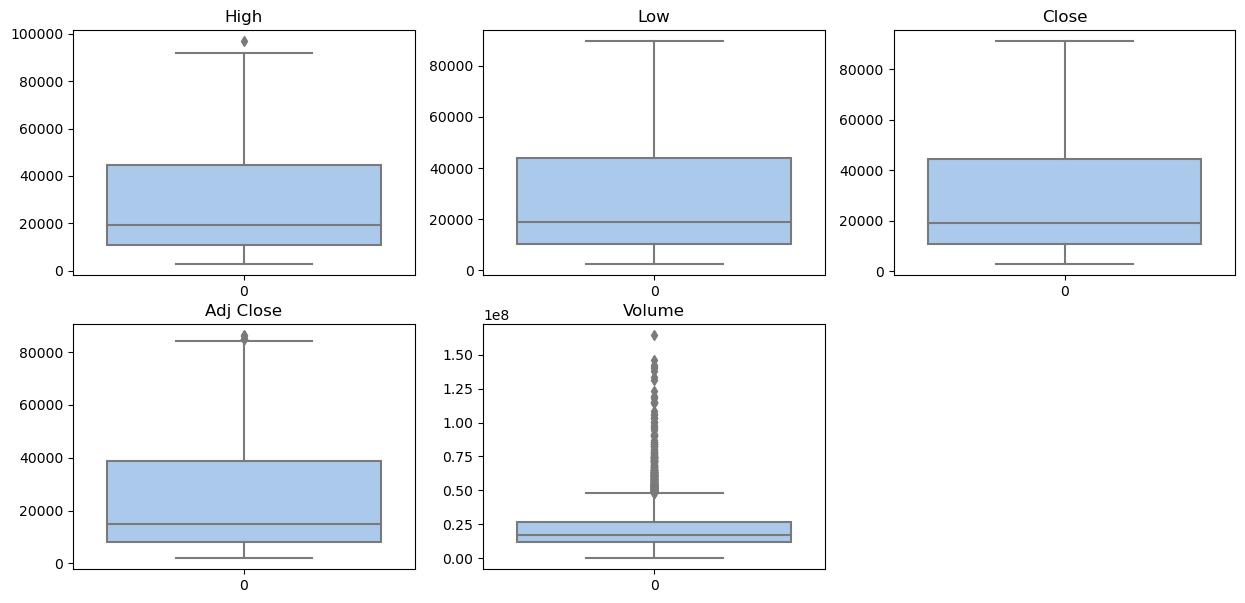

In [96]:
# boxplot

plt.figure(figsize=(15, 7))
for i, col in enumerate(df.columns[1:]):
    plt.subplot(2, 3, i+1)
    sns.boxplot(df[col])
    plt.title(col)

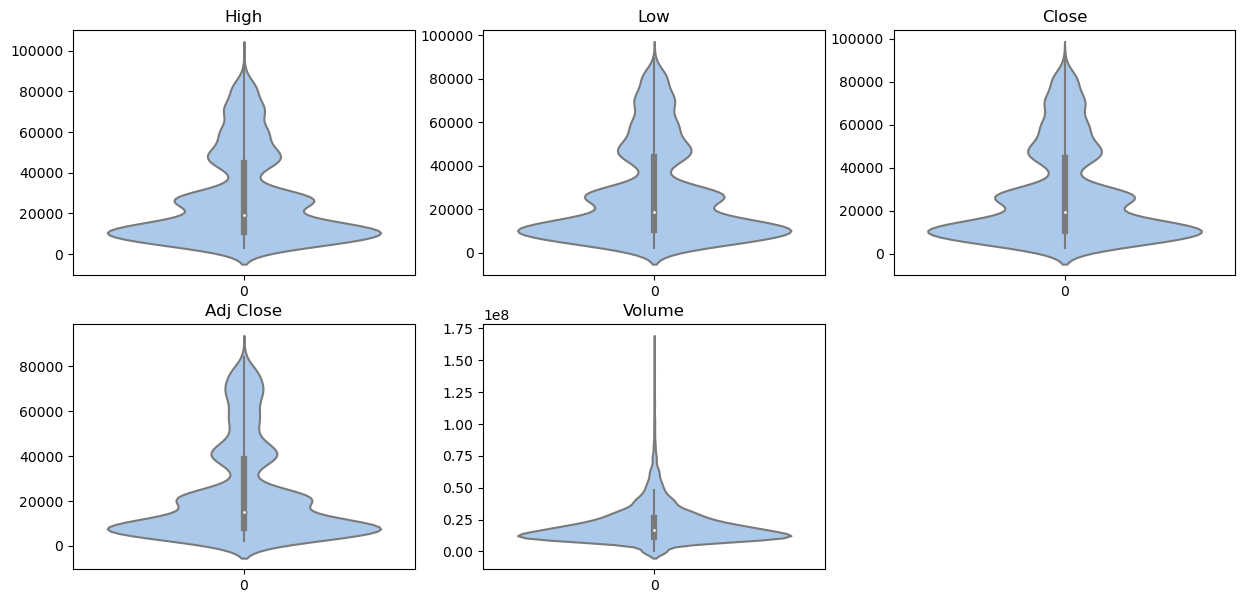

In [97]:
# voilinplot

plt.figure(figsize=(15, 7))
for i, col in enumerate(df.columns[1:]):
    plt.subplot(2, 3, i+1)
    sns.violinplot(df[col])
    plt.title(col)

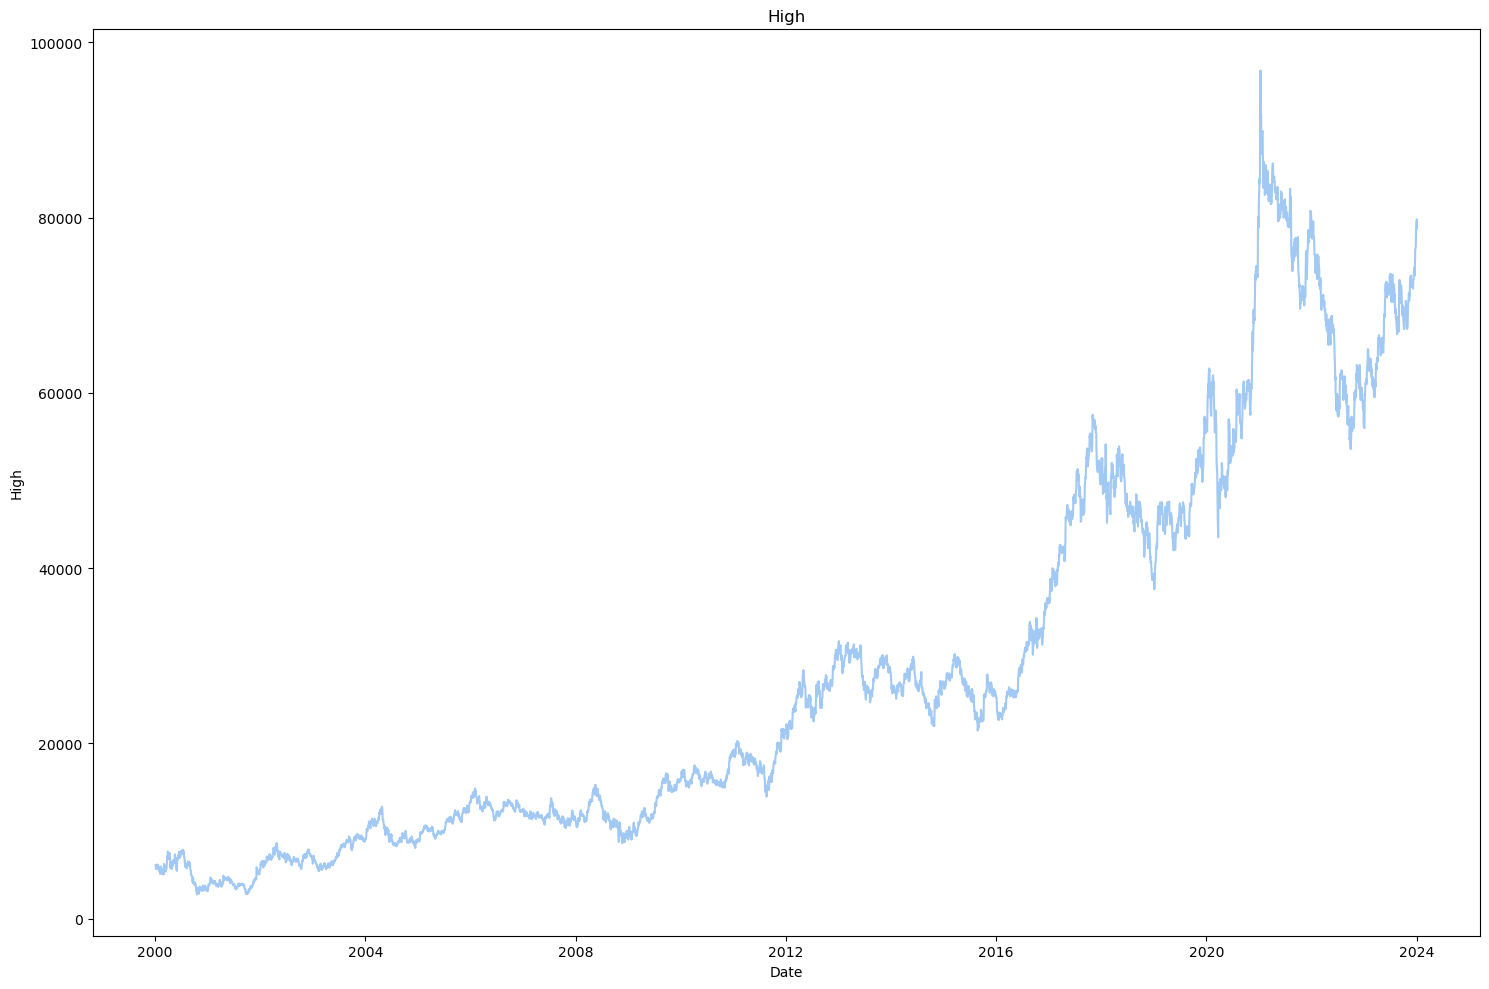

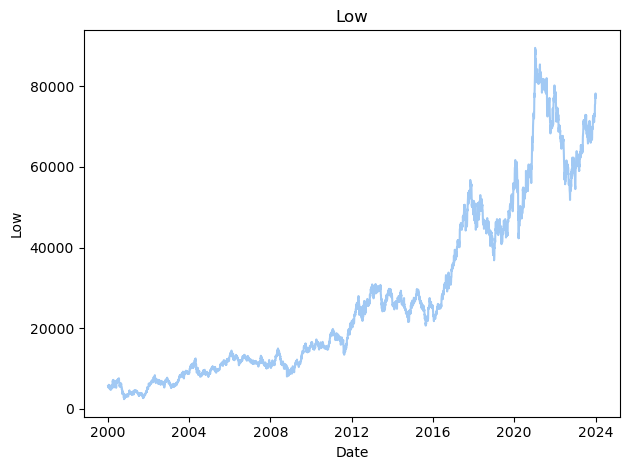

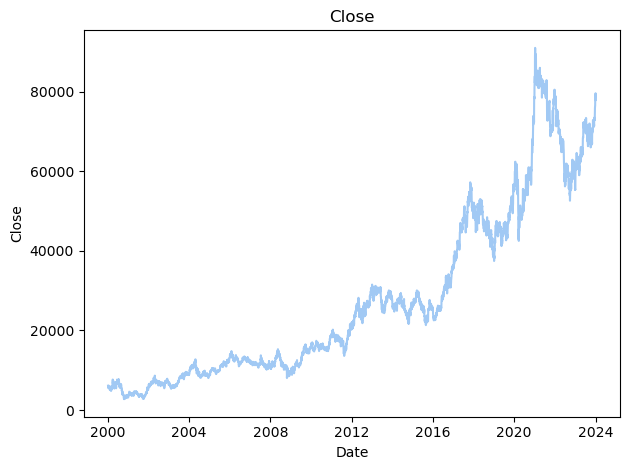

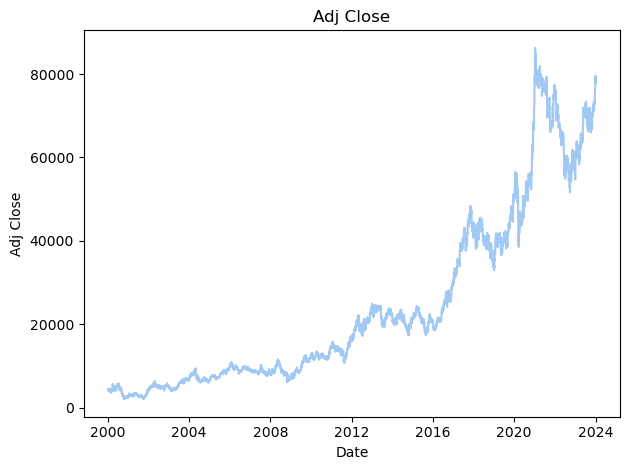

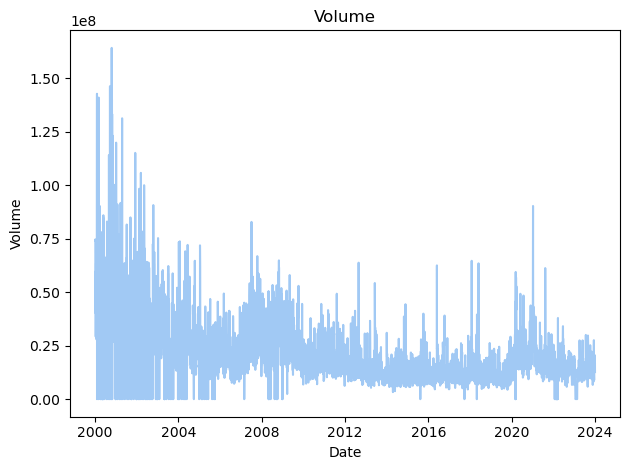

In [98]:
plt.figure(figsize=(15, 10))

for col in df.columns[1:]:
    sns.lineplot(x='Date', y=col, data=df)
    plt.title(col)
    plt.tight_layout()
    plt.show()

In [99]:
df['Volume'].replace(0, np.nan, inplace=True)
df.isna().sum(axis=0)

Open           0
High           0
Low            0
Close          0
Adj Close      0
Volume       127
dtype: int64

In [100]:
# Feature Extraction

df['MA3'] = df['Close'].rolling(window=3).mean().round() # 3일 이동평균
df['MA5'] = df['Close'].rolling(window=5).mean().round() # 5일 이동평균
df['MA10'] = df['Close'].rolling(window=10).mean().round() # 10일 이동평균

df['Mid'] = np.round((df['Open'] + df['Close']) / 2, 0) # 시가와 종가의 중간값

df['HL'] = df['High'] - df['Low'] # 고가와 저가의 차이
df['OC'] = df['Close'] - df['Open'] # 종가와 시가의 차이

df['RSI'] = df['Close'].rolling(window=14).apply(lambda x: x[-1] - x[0]).round() # RSI 지표

# df['std7'] = df['Close'].rolling(window=7).std().round() # 7일 이동표준편차
# df['std14'] = df['Close'].rolling(window=14).std().round() # 14일 이동표준편차
# df['std21'] = df['Close'].rolling(window=21).std().round() # 21일 이동표준편차




In [101]:
# 결측치 처리

df.dropna(inplace=True)

In [102]:
# train / test split


x = df[['Open', 'High', 'Low', 'Volume', 'MA3', 'MA5', 'MA10', 'Mid', 'HL', 'OC', 'RSI']]
y = df['Close']

train_size = int(len(x) * 0.8)
test_size = len(x) - train_size

x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(4703, 11) (1176, 11) (4703,) (1176,)


In [103]:
# y값 생성

def make_sequence_dataset(X, y, window_size): 
    feature_list = []
    label_list = []

    for i in range(len(X)-window_size):
        feature_list.append(X[i:i+window_size])
        label_list.append(y[i+window_size])

    return np.array(feature_list), np.array(label_list)

In [104]:
# 정규화
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

x_train, y_train = make_sequence_dataset(x_train, y_train, 20)
x_test, y_test = make_sequence_dataset(x_test, y_test, 20)

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(4683, 20, 11) (1156, 20, 11) (4683,) (1156,)


In [124]:
# 모델링

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

# return_sequences=True : 다음 레이어에게도 값을 전달
model = Sequential([
    LSTM(32, activation='tanh',return_sequences=True, input_shape=(20, 11)),
    LSTM(32, activation='tanh'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 20, 32)            5632      
                                                                 
 lstm_2 (LSTM)               (None, 32)                8320      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 15,041
Trainable params: 15,041
Non-trainable params: 0
_________________________________________________________________


2024-01-03 12:32:17.855204: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-01-03 12:32:17.855870: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-01-03 12:32:17.856259: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [125]:
from tensorflow.keras.optimizers.legacy import RMSprop

rmsprop = RMSprop(learning_rate=0.1)
model.compile(optimizer=rmsprop, loss='mse', metrics=['mse'])

In [126]:
from tensorflow.keras.callbacks import ModelCheckpoint

ckpt_path = '../save/samsung_stock.hdf5'
ckpt = ModelCheckpoint(ckpt_path, monitor='val_loss', verbose=1, save_best_only=True)

EPOCHS = 100
BATCH_SIZE = 32

history = model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2, callbacks=[ckpt])


Epoch 1/100


2024-01-03 12:32:25.856126: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-01-03 12:32:25.857994: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-01-03 12:32:25.858625: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

112/118 [===========================>..] - ETA: 0s - loss: 104534768.0000 - mse: 104534768.0000

2024-01-03 12:32:27.936937: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-01-03 12:32:27.937568: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-01-03 12:32:27.938104: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus


Epoch 1: val_loss improved from inf to 685846400.00000, saving model to ../save/samsung_stock.hdf5
118/118 [==============================] - 2s 10ms/step - loss: 102633408.0000 - mse: 102633408.0000 - val_loss: 685846400.0000 - val_mse: 685846400.0000
Epoch 2/100
111/118 [===========================>..] - ETA: 0s - loss: 40793656.0000 - mse: 40793656.0000
Epoch 2: val_loss improved from 685846400.00000 to 257583024.00000, saving model to ../save/samsung_stock.hdf5
118/118 [==============================] - 1s 7ms/step - loss: 39391868.0000 - mse: 39391868.0000 - val_loss: 257583024.0000 - val_mse: 257583024.0000
Epoch 3/100
114/118 [===========================>..] - ETA: 0s - loss: 10860113.0000 - mse: 10860113.0000
Epoch 3: val_loss improved from 257583024.00000 to 253780624.00000, saving model to ../save/samsung_stock.hdf5
118/118 [==============================] - 1s 7ms/step - loss: 10719026.0000 - mse: 10719026.0000 - val_loss: 253780624.0000 - val_mse: 253780624.0000
Epoch 4/10

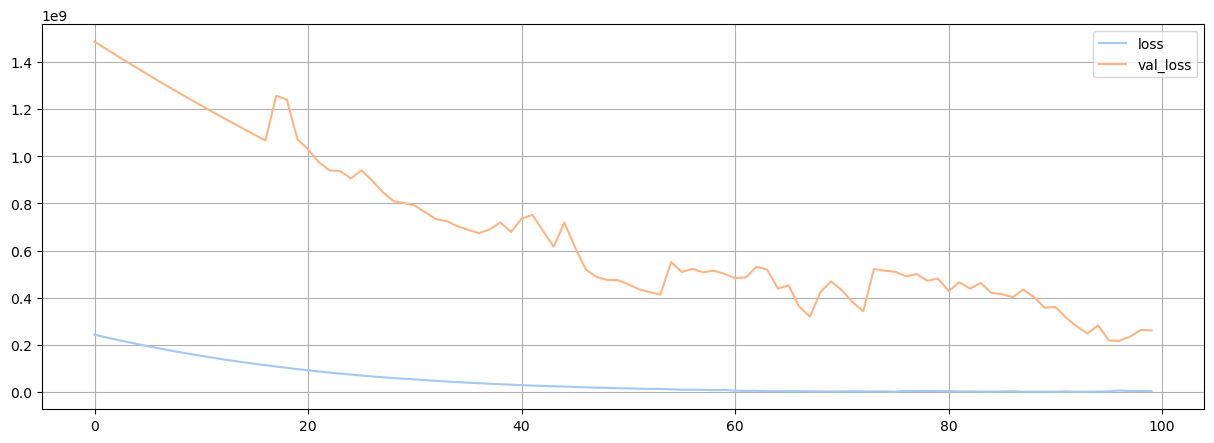

In [120]:
# loss, val_loss 시각화

plt.figure(figsize=(15, 5))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.grid()
plt.show()

In [121]:
# 모델 평가

from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error, mean_absolute_error

model = load_model(ckpt_path)

y_pred = model.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print('mse :', mse)
print('mae :', mae)

 1/37 [..............................] - ETA: 5s

2024-01-03 12:29:00.690637: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-01-03 12:29:00.691059: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-01-03 12:29:00.691652: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

37/37 [==============================] - 0s 899us/step
mse : 1804765535.5993252
mae : 39986.31175997513


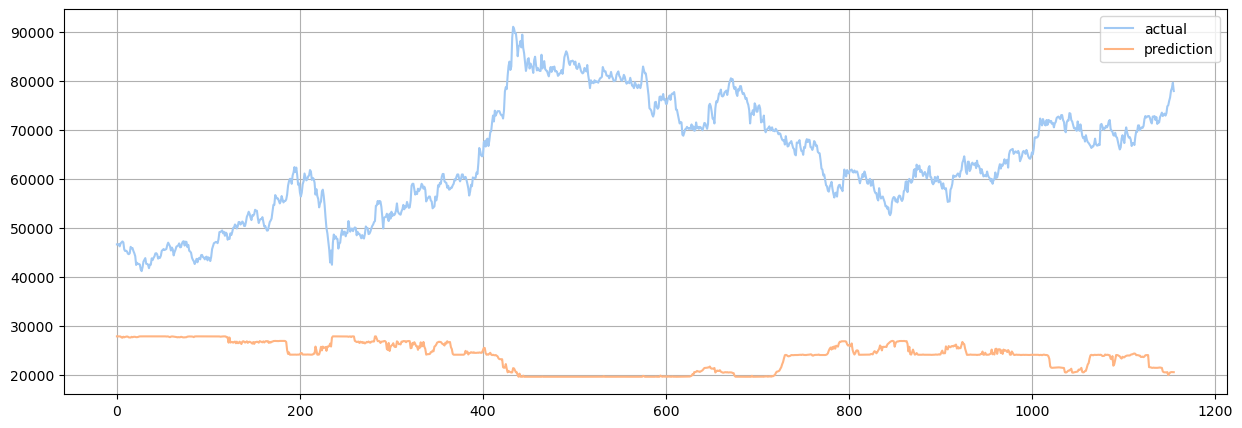

In [128]:
# 시각화

plt.figure(figsize=(15, 5))
plt.plot(y_test, label='actual')
plt.plot(y_pred, label='prediction')
plt.legend()
plt.grid()
plt.show()

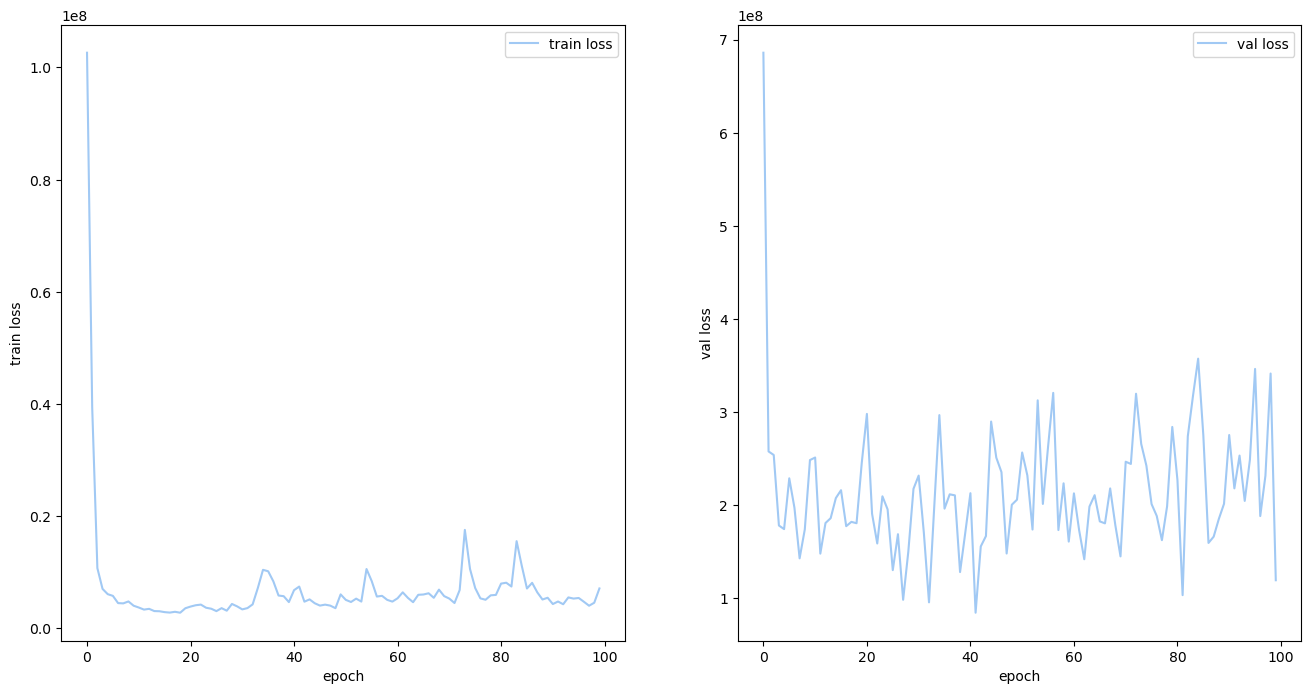

In [127]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(16, 8))
    plt.subplot(1,2,1)
    plt.xlabel('epoch')
    plt.ylabel('train loss')
    plt.plot(hist['epoch'], hist['loss'], label='train loss')
    
    plt.legend()

    plt.subplot(1,2,2)
    plt.xlabel('epoch')
    plt.ylabel('val loss')
    plt.plot(hist['epoch'], hist['val_loss'], label='val loss')
    plt.legend()
    plt.show()

plot_history(history)